# Uncertainty of Recurrent Neural Network model with dropout at predict time

This notebook demonstrates how dropout may be used at the time of predictions in order to estimate the machine learning model uncertainty. It is important to note that the model uncertainty does not account for the underlying uncertainty in the dataset, but rather the uncertainty provided by the machine learning algorithm itself. Do note that uncertainty analysis is not prioritized in this thesis, as the underlying uncertainty related to the fouling phenomena is largely unknown.

In recurrent networks, a parameter is used to determining whether dropout should be turned on or off at prediction time. If turned off, the model will automatically compute a mean value of predictions. This is typically the most robust approach if uncertainty analysis is not your main objective. However, if dropout is turned on during prediction, we are able to perform individual predictions and explore the randomness of the model. In this case, a number of N predictions are made, from which statistical measurements such as mean and standard deviation can be found.

For dataset *F*, 30min resolution and model type *B* is used. For dataset *G*, both 30min and 10min resolution are used, with model type *A* and model type *C*, respectively.

## Step 0: Import modules

In [1]:
# %load predict_with_uncertainty.py
import src.core as mlApi
import src.core_configs as configs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Step 1: Implement required methods

A method is implemented to plot predictions for a list of LSTM models using dropout at predict time.

In [2]:
def plotDropoutPrediction(modelList, predictions, means, stds, traintime=None):
    global df_test
    
    if traintime is not None:
        trainEndStr = [item for sublist in traintime for item in sublist]
    else:
        trainEndStr = None


    for i in range(len(modelList)):
        output_mean = means[i]
        output_std = stds[i]

        for j in range(output_mean.shape[-1]):
            mean = output_mean[:, j]
            std = output_std[:, j]

            upper = np.add(mean, std)
            lower = np.subtract(mean, std)

            fig, ax = plt.subplots(1, 1, figsize=(10,3), dpi=100)
            ax.set_xlabel('Date')
            ax.set_ylabel(mlApi._columnUnits[targetColumns[j]])
            ax.set_title(modelList[i].name + "\nPredictions and targets, " + mlApi._columnDescriptions[targetColumns[j]])
            ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, y_test[mlApi._maxEnrolWindow:, j], color="red", alpha=0.5, label="targets")
            ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, upper, color="grey", alpha=0.7, label="+/- 1 std bounds")
            ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, lower, color="grey", alpha=0.7)
            ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, mean, color="blue", alpha=1.0, label="prediction")
            ax.grid(1, axis='y')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 10})
            
            if trainEndStr:
                for i, trainEndString in enumerate(trainEndStr):
                    ax.axvline(x=pd.to_datetime(trainEndString, dayfirst=True), color='black' if i % 2 == 0 else 'blue', label='start training' if i % 2 == 0 else 'end training')

            plt.show()

# Dataset F

## Step 2: Define dataset specifics

In [3]:
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('F', 'A', '30min')

## Step 3: Initiate and divide data

In [4]:
df = mlApi.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Valve Opening C

Columns after removal: 
Col. 0 : FYN0111 - Process 

## Step 4: Define models | NB: only RNN (LSTM/GRU) models

In [5]:
lstmd_1x_128 = mlApi.LSTM('lstmd 1x128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
lstmd_2x_64 = mlApi.LSTM('lstmd 2x64 training', layers=[64, 64], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
gru_1x_128 = mlApi.GRU('grud 1x128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)

modelList = [
	lstmd_1x_128,
	lstmd_2x_64,
	gru_1x_128,
]

## Step 4: Initiate and train models

Model lstmd 1x128 training was loaded from file
Model lstmd 2x64 training was loaded from file
Model grud 1x128 training was loaded from file
+----------------------+-----------+-------------+---------------+--------+
|        Model         | Min. loss | Chosen loss | Min. val loss | Epochs |
+----------------------+-----------+-------------+---------------+--------+
| lstmd 1x128 training |  0.046872 |   0.060459  |    0.328755   |  431   |
| lstmd 2x64 training  |  0.060644 |   0.063491  |    0.327338   |  468   |
| grud 1x128 training  |  0.063218 |   0.075292  |    0.404615   |  275   |
+----------------------+-----------+-------------+---------------+--------+


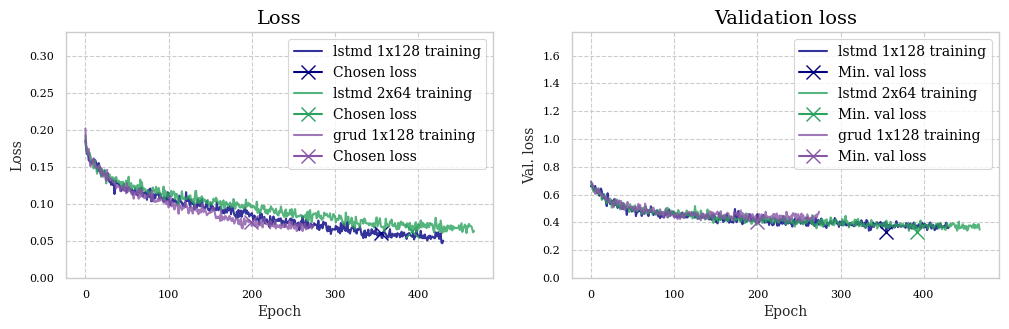

In [6]:
retrain=False
mlApi.initModels(modelList)
mlApi.trainModels(retrain)

## Step 5: Predict and plot

In [7]:
predictions, means, stds = mlApi.predictWithModelsUsingDropout(numberOfPredictions=30)

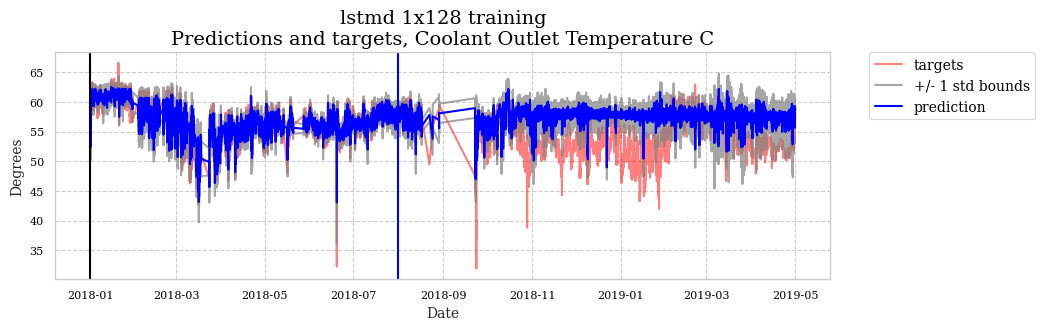

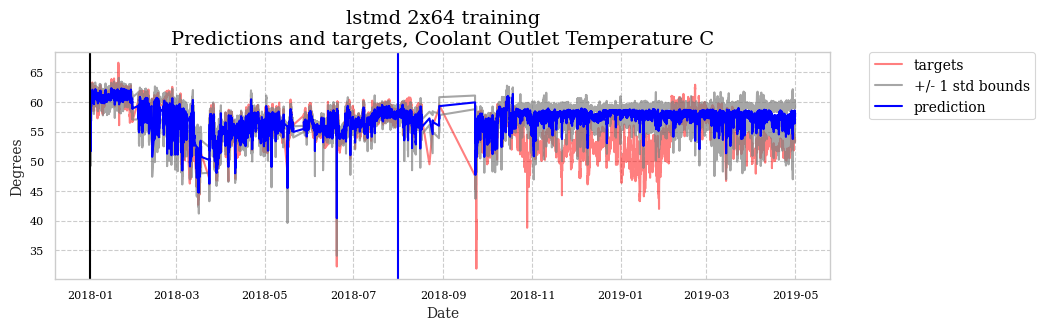

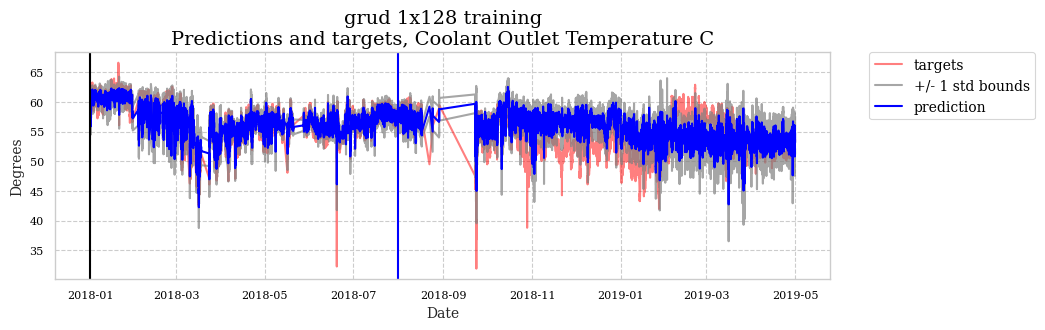

In [8]:
plotDropoutPrediction(modelList, predictions, means, stds, traintime)

In [9]:
mlApi.reset()

# Dataset G  30min

In [10]:
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('G', 'A', '30min')

In [11]:
df = mlApi.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows



In [12]:
lstmd_1x_128 = mlApi.LSTM('lstmd 1x128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
lstmd_2x_64 = mlApi.LSTM('lstmd 2x64 training', layers=[64, 64], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
gru_1x_128 = mlApi.GRU('grud 1x128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)

modelList = [
	lstmd_1x_128,
	lstmd_2x_64,
	gru_1x_128,
]

Model lstmd 1x128 training was loaded from file
Model lstmd 2x64 training was loaded from file
Model grud 1x128 training was loaded from file
+----------------------+-----------+-------------+---------------+--------+
|        Model         | Min. loss | Chosen loss | Min. val loss | Epochs |
+----------------------+-----------+-------------+---------------+--------+
| lstmd 1x128 training |  0.041897 |   0.066235  |    0.335926   |  314   |
| lstmd 2x64 training  |  0.063802 |   0.088087  |    0.337978   |  249   |
| grud 1x128 training  |  0.034117 |   0.048804  |    0.340421   |  500   |
+----------------------+-----------+-------------+---------------+--------+


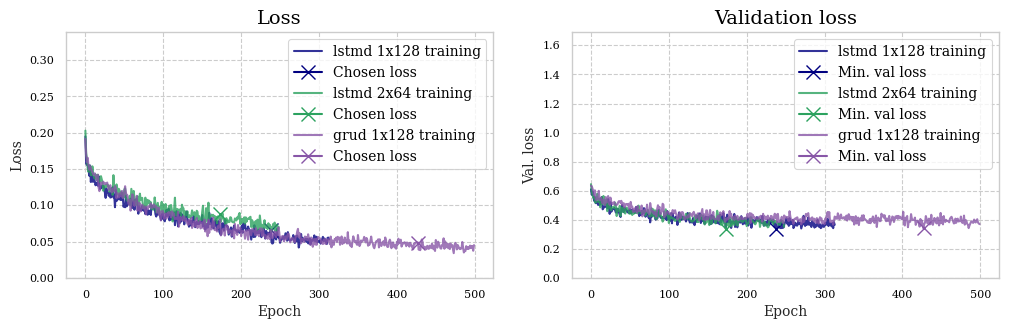

In [13]:
retrain=False
mlApi.initModels(modelList)
mlApi.trainModels(retrain)

In [14]:
predictions, means, stds = mlApi.predictWithModelsUsingDropout(numberOfPredictions=30)

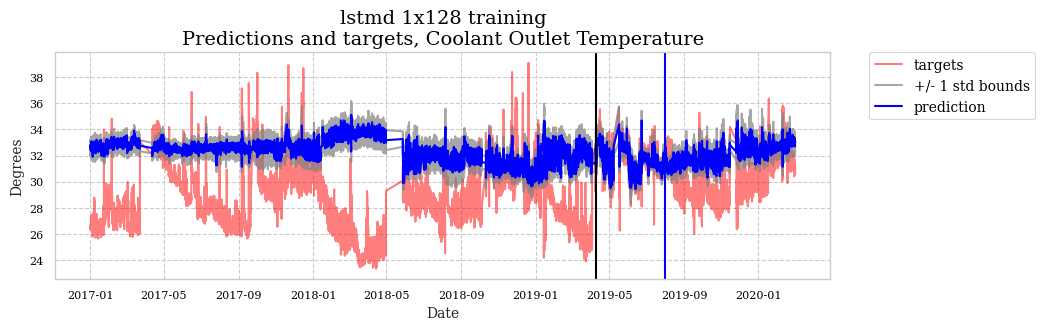

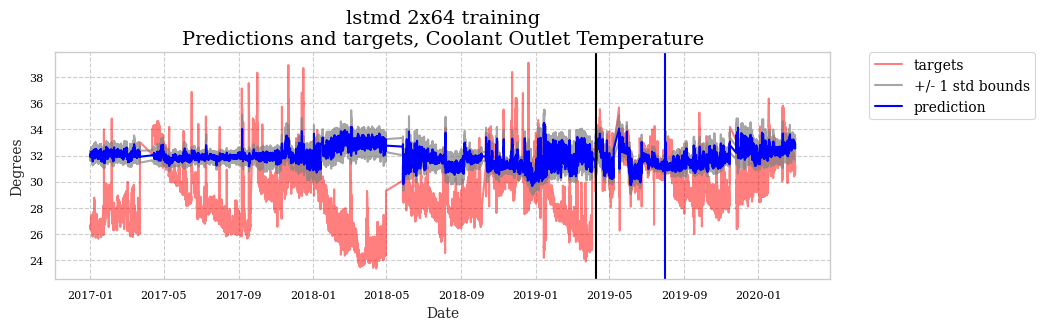

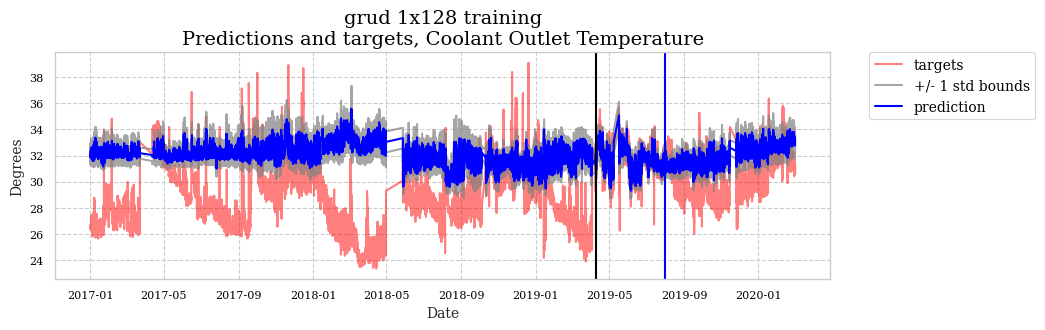

In [15]:
plotDropoutPrediction(modelList, predictions, means, stds, traintime)

In [16]:
mlApi.reset()

# Dataset G 10min

In [17]:
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('G', 'C', '10min')

In [18]:
df = mlApi.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 13885 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 146747 rows



In [19]:
lstmd_1x_128 = mlApi.LSTM('lstmd 1x 128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
lstmd_2x_64 = mlApi.LSTM('lstmd 2x 64 training', layers=[64, 64], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
gru_1x_128 = mlApi.GRU('grud 1x 128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)

modelList = [
	lstmd_1x_128,
	lstmd_2x_64,
	gru_1x_128,
]

Model lstmd 1x 128 training was loaded from file
Model lstmd 2x 64 training was loaded from file
Model grud 1x 128 training was loaded from file
+-----------------------+-----------+-------------+---------------+--------+
|         Model         | Min. loss | Chosen loss | Min. val loss | Epochs |
+-----------------------+-----------+-------------+---------------+--------+
| lstmd 1x 128 training |  0.045673 |   0.05689   |    0.365095   |  390   |
|  lstmd 2x 64 training |  0.05791  |   0.060306  |    0.36522    |  455   |
|  grud 1x 128 training |  0.05449  |   0.06008   |    0.396295   |  451   |
+-----------------------+-----------+-------------+---------------+--------+


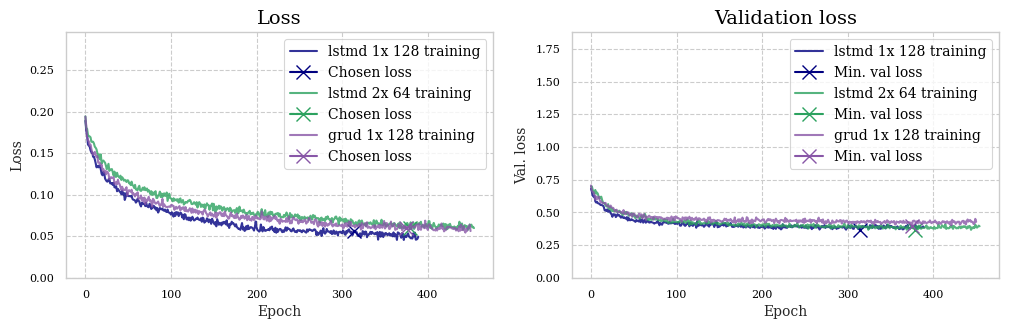

In [20]:
retrain=False
mlApi.initModels(modelList)
mlApi.trainModels(retrain)

In [21]:
predictions, means, stds = mlApi.predictWithModelsUsingDropout(numberOfPredictions=30)

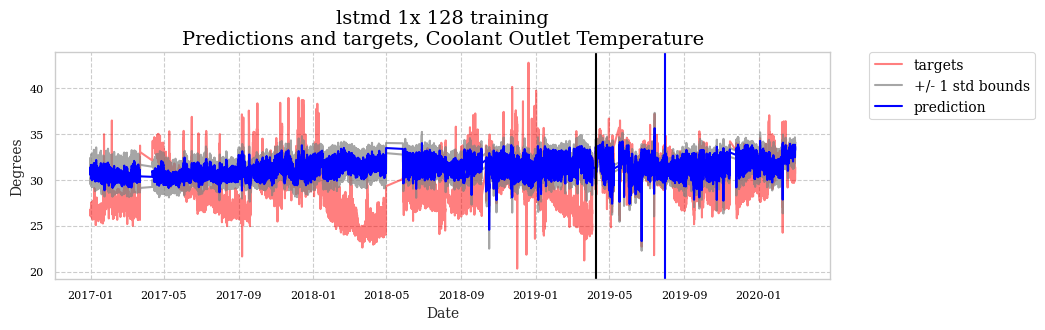

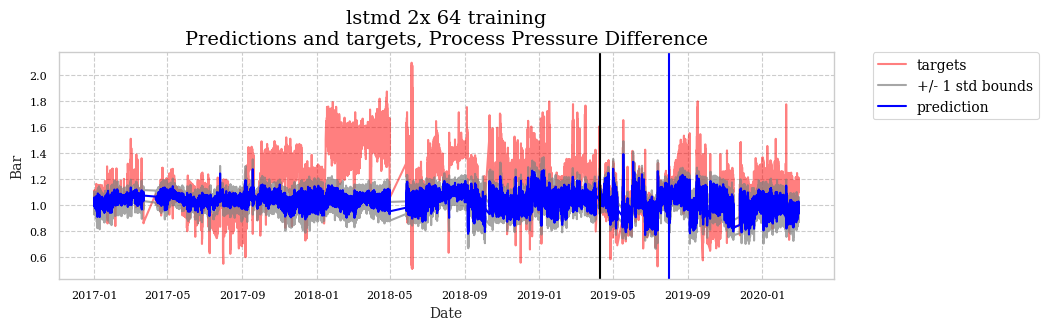

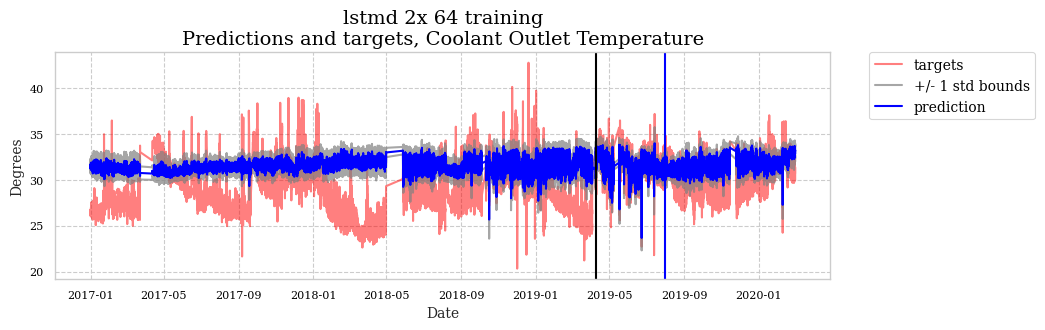

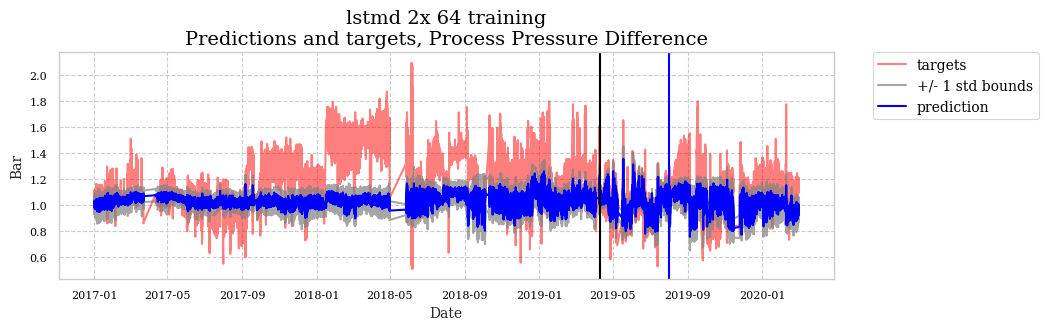

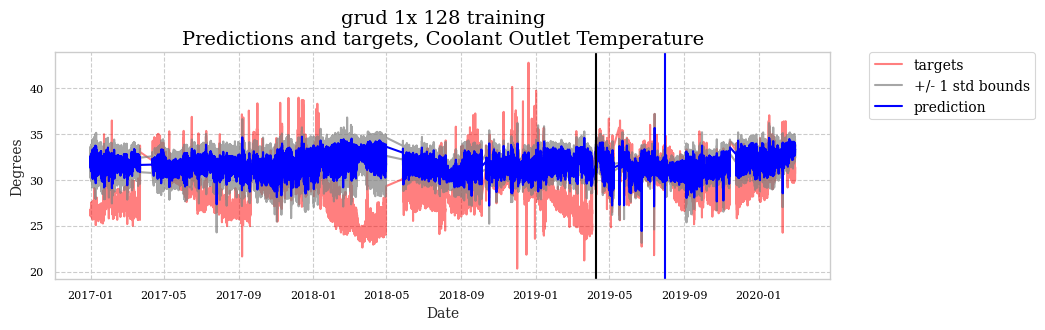

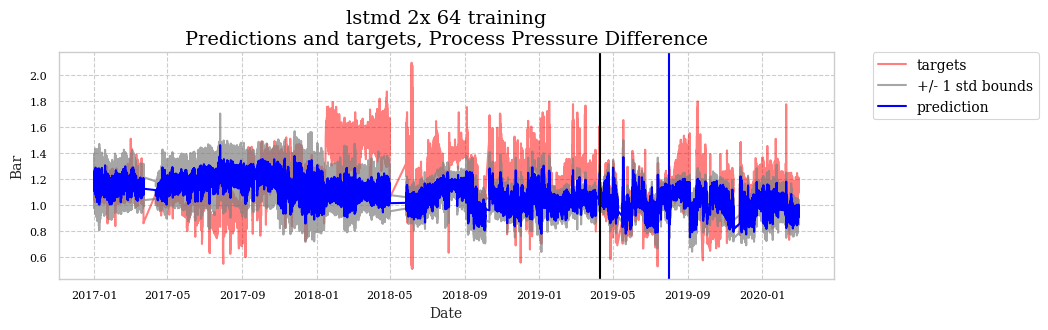

In [22]:
plotDropoutPrediction(modelList, predictions, means, stds, traintime)

The results are not discussed in detail here, as the purpose of this notebook is to describe the process of predicting with uncertainty. Even so, it should be noted that the GRU model does not seem to generalize to the testing data very well. This may come as a surprise considering the model itself has converged for the training data with only slightly higher validation loss than the LSTM model. Predictions for this model are in general not in line with what is expected, and the uncertainty of the model is large. The LSTM model is assumed to give a more realistic fouling indicator.